In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import dill as pickle

import quail
import requests
import os
import warnings

from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

# Download/organize the data

In [2]:
# set up labels and directories

datadir = os.path.join(os.path.split(os.getcwd())[0], 'data', 'eggs')
if not os.path.exists(datadir):
    os.makedirs(datadir)

urls = {
    'exp1': 'https://www.dropbox.com/s/wbihewq631onsj8/exp1.egg?dl=1',
    'exp2': 'https://www.dropbox.com/s/kliq92lta7mvqcc/exp2.egg?dl=1',
    'exp3': 'https://www.dropbox.com/s/3se8ee2fahf9hvc/exp3.egg?dl=1',
    'exp4': 'https://www.dropbox.com/s/9xd2v4fofk1uqv2/exp4.egg?dl=1',
    'exp5': 'https://www.dropbox.com/s/lox770xxs2d7ypm/exp5.egg?dl=1',
    'exp6': 'https://www.dropbox.com/s/afp5ml563b46s6q/exp6.egg?dl=1',
    'exp7': 'https://www.dropbox.com/s/43nq4egicrxc31p/exp7.egg?dl=1',
    'exp8': 'https://www.dropbox.com/s/j7j2bldr24wybwu/exp8.egg?dl=1',
    'exp10': 'https://www.dropbox.com/s/gp3av93kvlzsgpw/exp10.egg?dl=1',
    'exp11': 'https://www.dropbox.com/s/5227s2pg5o8krda/exp11.egg?dl=1',
    'exp12': 'https://www.dropbox.com/s/leqll4o8ih587fa/exp12.egg?dl=1'
    }

descriptions = {
    'exp1': 'feature rich',
    'exp2': 'category',
    'exp3': 'color',
    'exp4': 'length',
    'exp5': 'first letter',
    'exp6': 'location',
    'exp10': 'size',
    'exp7': 'reduced (early)',
    'exp8': 'reduced (late)',                
    'exp12': 'reduced',
    'exp11': 'adaptive'
    }

feature_groupings = {
    'random': ['feature rich', 'reduced (early)', 'reduced (late)', 'reduced'],
    'semantic': ['category', 'size'],
    'lexicographic': ['length', 'first letter'],
    'visual': ['color', 'location'],
    'adaptive': ['random', 'stabilize', 'destabilize']
    }

colors = {
    'feature rich': '#c0673c',
    'reduced (early)': '#f15a22',
    'reduced (late)': '#f7996c',
    'reduced': '#fddac5',
    'category': '#524fa1',
    'size': '#aca7d3',
    'length': '#cbdb2a',
    'first letter': '#e8eeae',
    'color': '#00a651',
    'location': '#9bd3ae',
    'random': '#407b8d',
    'stabilize': '#00addc',
    'destabilize': '#90d7ee'
}

def grouping(feature):
    try:
        return [k for k, v in feature_groupings.items() if feature in v][0]
    except:
        return None

In [3]:
# (down)load the data from each experimental condition
def load_egg(fname, url=None):    
    fname = os.path.join(datadir, fname)
    if os.path.exists(fname):
        print('.', end='')
        return quail.load_egg(fname)

    print('o', end='')
    r = requests.get(url, allow_redirects=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    
    return load_egg(fname)

def fetch_data():
    print('loading data', end='')
    data = {descriptions[x]: load_egg(f'{x}.egg', u) for x, u in urls.items()}
    print('done!')

    return data

# Do some basic analyses

Compute for each experiment:
- Probability of first recall (pfr): plot probability of recalling each item *first* as a function of the presentation position
    - Advanced: also do probability of $n^{th}$ recall for $n \in \{0, ..., 15\}$
- Lag conditional response probability (lagcrp): plot the probability of recalling each item next in the sequence, as a function of their positions relative to the position of the item recalled just previously
- Serial position curve (spc): plot the probability of recalling each item (at *any* point) as a function of the presentation position
- Fingerprint: compute clustering scores across different features

For each analysis:
- Look at "early" vs. "late" lists

### To do:
- Use word2vec or GLoVE to compute word embeddings (tag as "semantic" features)

In [4]:
def apply(egg, analysis):
    warnings.simplefilter('ignore')

    if 'listgroup' not in egg.meta:
        listgroup = ['Early' if i < 8 else 'Late' for i in range(16)]
    else:
        listgroup = egg.meta['listgroup']

    if type(analysis) is str:
        kwargs = {}
    else:
        analysis, kwargs = analysis
    
    return egg.analyze(analysis, listgroup=listgroup, **kwargs)


def analyze_data(data, analyses):
    results = {}

    print('basic analyses...')
    for a in tqdm(analyses):
        results[a] = {x: apply(d, a) for x, d in data.items()}
    
    print('pnr analyses...')
    pnr_results = {}
    for i in tqdm(range(16)):
        pnr_results[i] = {x: apply(d, ['pfr', {'position': i}]) for x, d in data.items()}

    results['pnr'] = pnr_results
    return results

In [5]:
results_file = os.path.join(datadir, 'analyzed.pkl')

if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        results, analyses = pickle.load(f)
else:
    data = fetch_data()
    analyses = ['lagcrp', 'spc', 'accuracy', 'fingerprint']
    results = analyze_data(data, analyses)
    with open(results_file, 'wb') as f:
        pickle.dump([results, analyses], f)

Set up figure directory...

In [6]:
figdir = os.path.join(os.path.split(os.getcwd())[0], 'paper', 'figures', 'source')
if not os.path.exists(figdir):
    os.makedirs(figdir)

# Figure 1: recall dynamics across different experimental conditions

We'll use three basic analyses to characterize recall dynamics:
  - What word do participants recall *first*?  (Probability of first recall)
  - How to participants *transition* from recalling one word to recalling other words (from the same list)?  (Lag Conditional Response Probability)
  - Which words do participants recall *overall*? (Serial position curve)

In [18]:
non_adaptive = [x for x in descriptions.values() if x != 'adaptive']

def select_conds(results, conds='all'):
    return {k: v for k, v in results.items() if conds == 'all' or k in conds}

def select_lists(fried, lists='all'):
    if type(fried) is dict:
        return {k: select_lists(v, lists=lists) for k, v in fried.items()}

    x_data = fried.data.copy()
    if lists == 'all':
        x_data.index = pd.MultiIndex.from_tuples([(i, 'Average') for i, _ in x.data.index], names=x.data.index.names)        
    elif type(lists) is str:
        x_data = x_data.query(f'List == "{lists}"')
    else:
        x_data = x_data.query(f'List in @lists')

    return quail.FriedEgg(data=x_data.copy(), analysis=fried.analysis, list_length=fried.list_length,
                          n_lists=fried.n_lists, n_subjects=fried.n_subjects, position=fried.position)


def filter(x, include_conds='all', include_lists='all'):
    def get_conds(x, conds):
        if conds == 'all':
            conds = list(x.keys())
            conds.sort()
        elif type(conds) is str:
            conds = [conds]
        return conds
    
    def get_lists(x, lists, conds):        
        if lists == 'all':
            lists = []
            for c in conds:
                lists.extend(np.unique([i for _, i in x[c].data.index]).tolist())
            lists = np.unique(lists).tolist()
        elif type(lists) is str:
            lists = [lists]
        return lists
    
    def get_conds_and_lists(x, conds, lists):
        conds = get_conds(x, conds)
        lists = get_lists(x, lists, conds)
        return conds, lists


    def helper(x, conds, lists):
        if type(conds) is str:
            conds = [conds]
        if type(lists) is str:
            lists = [lists]

        agg_conds, agg_lists = conds.copy(), lists.copy()
        
        if type(x) is dict:            
            for k, v in x.items():
                if type(v) is dict:
                    next_conds, next_lists = helper(v, [], [])
                elif type(v) is list:
                    _, next_conds, next_lists = v
                elif type(v) is quail.FriedEgg:
                    next_conds = []
                    next_lists = np.unique([x[1] for x in v.data.index.values]).tolist()
                else:
                    next_conds, next_lists = [], []
                
                agg_conds.extend(next_conds)
                agg_lists.extend(next_lists)
            
            return np.unique(agg_conds).tolist(), np.unique(agg_lists).tolist()
        else:
            return agg_conds, agg_lists

    if type(x) is dict:
        filtered = {}
        for k, v in x.items():
            if type(v) is dict:
                filtered[k] = {a: filter(b, include_conds=include_conds, include_lists=include_lists) for a, b in v.items()}
            elif type(v) is quail.FriedEgg and (include_conds == 'all' or k in include_conds):
                filtered[k] = select_lists(v, include_lists)
    elif type(x) is quail.FriedEgg:
        return select_lists(x, include_lists), include_conds, include_lists
    
    include_conds, include_lists = helper(filtered, include_conds, include_lists)
    return filtered, include_conds, include_lists

def combo_plot(x, include_conds='all', include_lists='all', fname=None, xlabel=None, ylabel=None, xlim=None, ylim=None, palette=None):
    x, include_conds, include_lists = filter(x, include_conds, include_lists)

    fig = plt.figure(figsize=(3, 2.5))
    ax = plt.gca()
    
    for c in include_conds:
        if palette is None:
            if c.lower() in colors:
                next_palette = [colors[c.lower()]]
            else:
                next_palette = [colors[i.lower()] for i in include_lists]
        else:
            next_palette = palette
    
        x[c].plot(ax=ax, palette=next_palette, legend=False)
    
    if xlabel is not None:
        plt.xlabel(xlabel)
    
    if ylabel is not None:
        plt.ylabel(ylabel)

    if xlim is not None:
        plt.xlim(xlim)
    
    if ylim is not None:
        plt.ylim(ylim)
    
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    if fname is not None:
        fig.savefig(os.path.join(figdir, fname + '.pdf'), bbox_inches='tight')
    
    return fig

Probability of first recall (early + late)

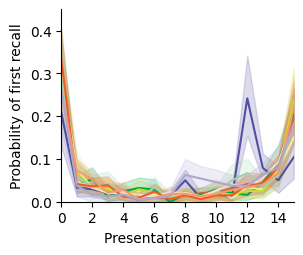

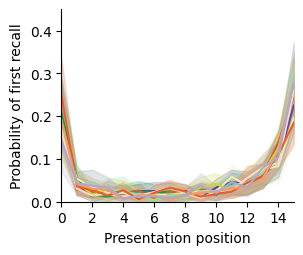

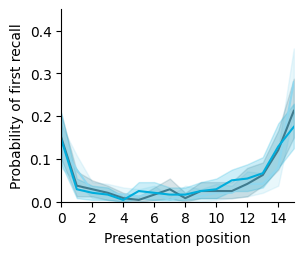

In [19]:
combo_plot(results['pnr'][0], include_conds=non_adaptive, include_lists='Early', fname='pfr_early_nonadaptive', xlabel='Presentation position', ylabel='Probability of first recall', ylim=[0, 0.45]);
combo_plot(results['pnr'][0], include_conds=non_adaptive, include_lists='Late', fname='pfr_late_nonadaptive', xlabel='Presentation position', ylabel='Probability of first recall', ylim=[0, 0.45]);
combo_plot(results['pnr'][0], include_conds='adaptive', include_lists=['destabilize', 'random', 'stabilize'], fname='pfr_adaptive', xlabel='Presentation position', ylabel='Probability of first recall', ylim=[0, 0.45]);

Lag conditional response probability

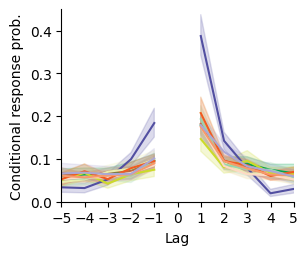

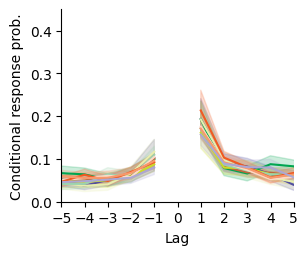

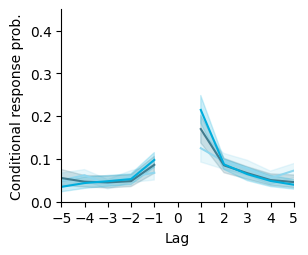

In [20]:
combo_plot(results['lagcrp'], include_conds=non_adaptive, include_lists='Early', fname='crp_early_nonadaptive', xlabel='Lag', ylabel='Conditional response prob.', ylim=[0, 0.45]);
combo_plot(results['lagcrp'], include_conds=non_adaptive, include_lists='Late', fname='crp_late_nonadaptive', xlabel='Lag', ylabel='Conditional response prob.', ylim=[0, 0.45]);
combo_plot(results['lagcrp'], include_conds='adaptive', include_lists=['destabilize', 'random', 'stabilize'], fname='crp_adaptive', xlabel='Lag', ylabel='Conditional response prob.', ylim=[0, 0.45]);

Serial position curves

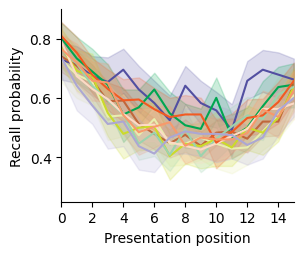

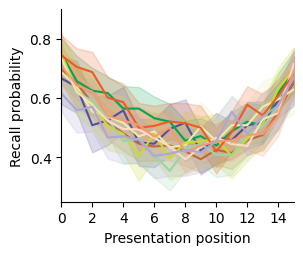

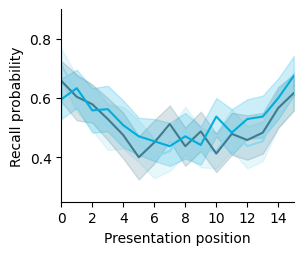

In [21]:
combo_plot(results['spc'], include_conds=non_adaptive, include_lists='Early', fname='spc_early_nonadaptive', xlabel='Presentation position', ylabel='Recall probability', ylim=[0.25, 0.9]);
combo_plot(results['spc'], include_conds=non_adaptive, include_lists='Late', fname='spc_late_nonadaptive', xlabel='Presentation position', ylabel='Recall probability', ylim=[0.25, 0.9]);
combo_plot(results['spc'], include_conds='adaptive', include_lists=['destabilize', 'random', 'stabilize'], fname='spc_adaptive', xlabel='Presentation position', ylabel='Recall probability', ylim=[0.25, 0.9]);

# Figure 2: early versus late differences in recall dynamics

For the non-adaptive conditions, recall dynamics on early vs. late lists reflect performance under difference conditions:
  - Feature rich, reduced: control conditions
    - Feature rich: random word order on both early and late lists; visual features vary across words
    - Reduced: random word order on both early and late lists; visual features held constant across words
  - Category, size, length, first letter, color, location
    - Words are sorted by the given feature during the first 8 lists ("Early")
    - Words order is randomized for the second 8 lists ("Late")
  - Reduced (early), Reduced (late):
    - Word order is randomized in all lists, for both conditions
    - Reduced (early): visual features are held constant for the first 8 lists ("Early") but vary for the second 8 lists ("Late")
    - Reduced (late): visual features vary for the first 8 lists but are held constant for the second 8 lists

# STOPPED HERE...

In [22]:
def egg_diff(a, b):
    if type(a) is dict:
        results = {}
        for k in a.keys():
            results[k] = egg_diff(a[k], b[k])
        return results
    
    for i in ['analysis', 'list_length', 'n_lists', 'n_subjects', 'position']:
        assert getattr(a, i) == getattr(b, i), ValueError('Incompatable eggs; cannot take difference')
    assert np.all([i == j for i, j in zip(a.data.shape, b.data.shape)]), ValueError('Incompatable eggs; cannot take difference')
    
    idx = pd.MultiIndex.from_tuples([(i, 'Difference') for i, _ in a.data.index], names=a.data.index.names)
    diffs = pd.DataFrame(index=idx, data=a.data.values - b.data.values, columns=a.data.columns)

    return quail.FriedEgg(data=diffs, analysis=a.analysis, list_length=a.list_length,
                          n_lists=a.n_lists, n_subjects=a.n_subjects, position=a.position)
    
def get_diffs(x, contrast={'Late': 'Early'}, include_conds='all' ):
    include_lists = []
    for k, v in contrast.items():
        include_lists.extend([k, v])
    include_lists = np.unique(include_lists).tolist()

    x, include_conds, include_lists = filter(x, include_conds, include_lists)
    
    diffs = {}
    for k, v in contrast.items():
        diffs[f'{k} - {v}'] = egg_diff(select_lists(x, k), select_lists(x, v))

    return diffs

In [23]:
diffs = get_diffs(results, include_conds=non_adaptive)

AttributeError: 'tuple' object has no attribute 'data'

In [137]:
diffs['Late - Early']

{}

In [ ]:
combo_plot(results['spc'], include_conds=non_adaptive, include_lists='Early', fname='spc_early_nonadaptive', xlabel='Presentation position', ylabel='Recall probability', ylim=[0.25, 0.9]);
combo_plot(results['spc'], include_conds=non_adaptive, include_lists='Late', fname='spc_late_nonadaptive', xlabel='Presentation position', ylabel='Recall probability', ylim=[0.25, 0.9]);
combo_plot(results['spc'], include_conds='adaptive', include_lists=['destabilize', 'random', 'stabilize'], fname='spc_adaptive', xlabel='Presentation position', ylabel='Recall probability', ylim=[0.25, 0.9]);

for each type of (main) analysis:

Figure 1:
  - Panel 1: early lists for non-adaptive conditions
  - Panel 2: late lists for non-adaptive conditions
  - Panel 3: adaptive conditions

Figure 2:
  - Panel 1: early vs. late diffs (late - early)
  - Panel 2: stabilize - random, destabilize - random

pfr, lagcrp, spc: line plots
fingerprint, accuracy: bar plots

---

Figure 3 (aggregate across all conditions/experiments):
  Pnr analyses (for non-adaptive conditions); row: condition, column: position

---

Figure 4: list order effects by condition
  - bar plot of recall accuracy (group: list number; color: condition)

---

Figure 5: Fingerprint "carryover" by feature type (non-adaptive, non-random feature rich only)
  - Scatterplot (color = condition) showing late - early clustering difference (for the given feature type) vs. late - early accuracy
    - idea: does more carryover from early lists increase (or decrease) accuracy on late lists, for any type(s) of features?

---

Figure 6: effects of features:
  - Panel 1: feature rich - reduced for early lists
  - Panel 2: feature rich - reduced for late lists
  - Panel 3: reduced (late) - reduced for late lists
  - Panel 4: feature rich - reduced (early) for late lists

---

Figure 7 (adaptive only)
  Panel 1: Distance from average fingerprint up to that point, by listgroup (x = list number within group; y = distance)
  Panel 2: variance in fingerprints over time, by listgroup
  Panel 3: scatterplot (each listgroup = different color, list number within group = size) where x = distance between current fingerprint vs. average prior to that point and y = accuracy
  

Figure 8: (adaptive only)
  - Panel 1: random; Panel 2: stabilize; Panel 3: destabilize
  - Scatter plots showing (for each feature) average fingerprint (for that feature dimension) on x axis and accuracy (overall) on y axis

In [101]:
results['pfr']['exp1']

<AxesSubplot: xlabel='Position', ylabel='Probability of Recall: Position 0'>

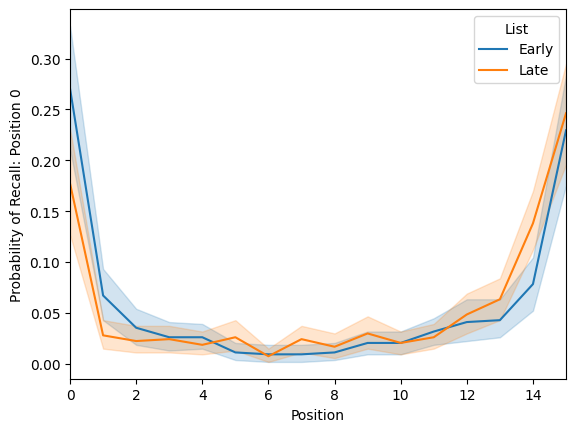

In [95]:
results['pfr']['exp1'].plot()

<AxesSubplot: xlabel='Position', ylabel='Probability of Recall: Position 0'>

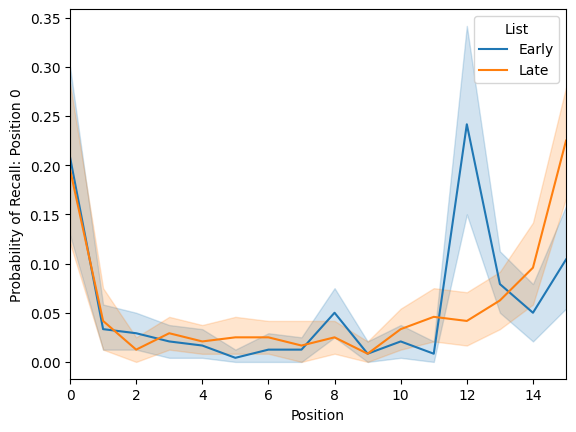

In [96]:
results['pfr']['exp2'].plot()

<AxesSubplot: xlabel='Position', ylabel='Probability of Recall: Position 0'>

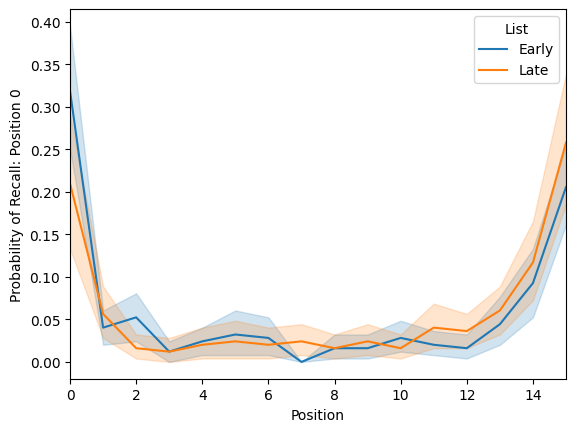

In [97]:
results['pfr']['exp3'].plot()